In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

sns.set_theme(color_codes=True)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/college/College Project/Laptop Price Prediction/laptops_train.csv')
data.head()

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20


# Data Preprocessing Part 1

In [ ]:
data['Weight'] = data['Weight'].str.strip('kg')
data['Screen Size'] = data['Screen Size'].str.strip('"')
data.head()

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37,11912523.48
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34,7993374.48
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86,5112900.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83,22563005.40
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37,16037611.20


In [ ]:
data.dtypes

Manufacturer                 object
Model Name                   object
Category                     object
Screen Size                  object
Screen                       object
CPU                          object
RAM                          object
 Storage                     object
GPU                          object
Operating System             object
Operating System Version     object
Weight                       object
Price                       float64
dtype: object

In [ ]:
data['Weight'] = data['Weight'].astype(float, errors='raise')
data['Screen Size'] = data['Screen Size'].astype(float, errors='raise')

In [ ]:
data.dtypes

Manufacturer                 object
Model Name                   object
Category                     object
Screen Size                 float64
Screen                       object
CPU                          object
RAM                          object
 Storage                     object
GPU                          object
Operating System             object
Operating System Version     object
Weight                      float64
Price                       float64
dtype: object

In [ ]:
def fetch_processor(text):
    if 'Intel Core i5' in text:
        return 'Intel Core i5'
    elif 'Intel Core i7' in text:
        return 'Intel Core i7'
    elif 'Intel Core i3' in text:
        return 'Intel Core i3'
    elif text.startswith('Intel'):
        return 'Other Intel Processor'
    else:
        return 'AMD Processor'

In [ ]:
data['CPU brand'] = data['CPU'].apply(fetch_processor)

<Axes: >

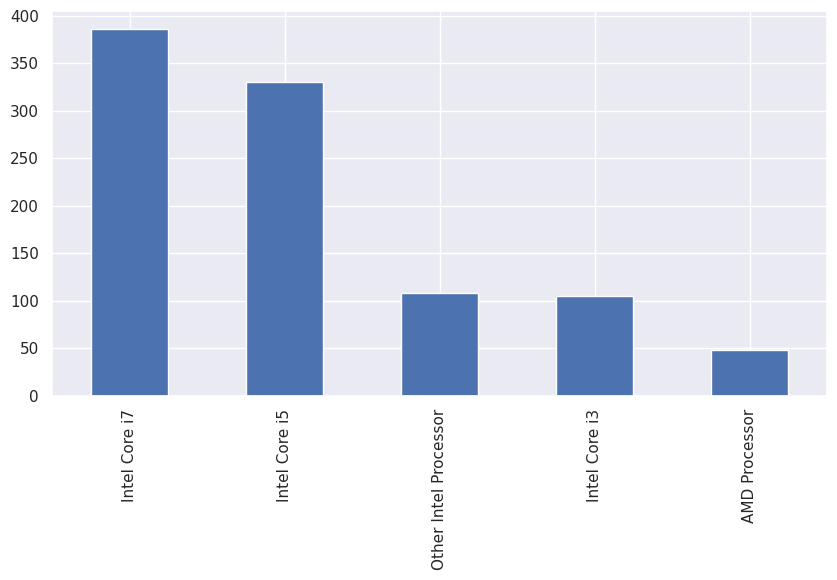

In [ ]:
plt.figure(figsize=(10,5))
data['CPU brand'].value_counts().plot(kind='bar')

In [ ]:
def gpu_type(text):
    if 'Intel' in text:
        return 'Intel'
    elif 'AMD' in text:
        return 'AMD'
    elif 'Nvidia' in text:
        return 'Nvidia'
    else:
        return 'Other GPU'

In [ ]:
data['GPU brand'] = data['GPU'].apply(gpu_type)

<Axes: >

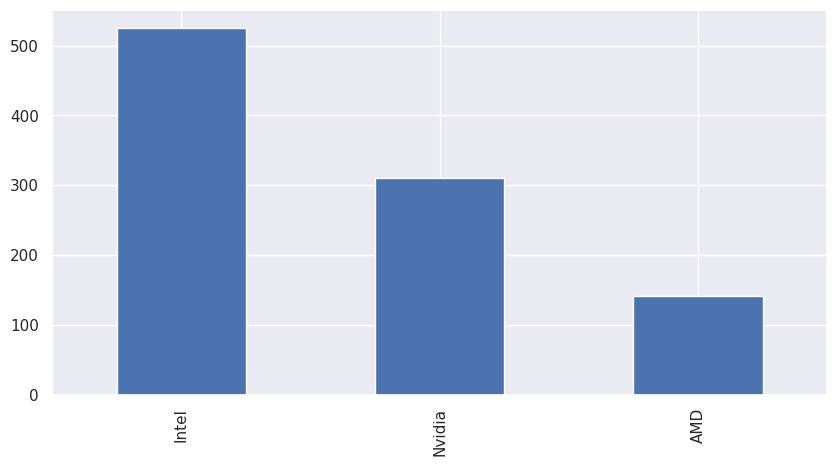

In [ ]:
plt.figure(figsize=(10,5))
data['GPU brand'].value_counts().plot(kind='bar')

In [ ]:
data['Operating System'] = data['Operating System'].replace('Mac OS', 'macOS')

In [ ]:
data['Screen Quality'] = data['Screen'].str.slice(-9)

<Axes: >

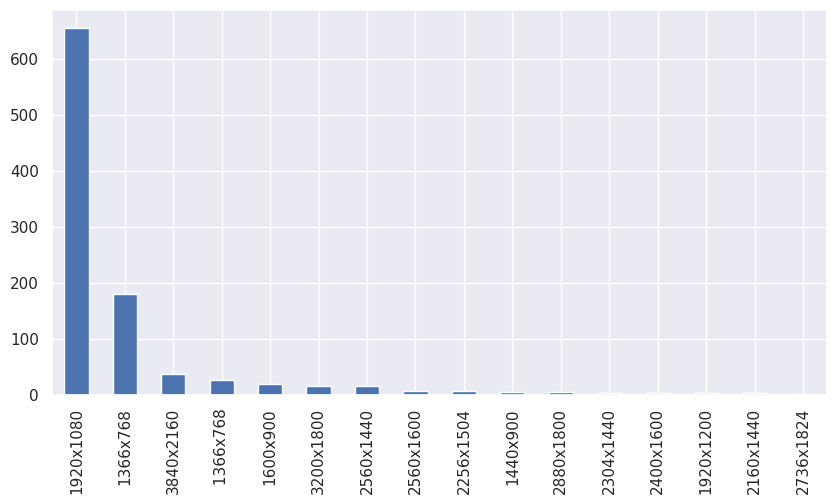

In [ ]:
plt.figure(figsize=(10,5))
data['Screen Quality'].value_counts().plot(kind='bar')

In [ ]:
def fetch_storage(text):
    if '128GB SSD' in text:
        return '128GB SSD'
    elif '256GB SSD' in text:
        return '256GB SSD'
    elif '512GB SSD' in text:
        return '512GB SSD'
    elif '500GB HDD' in text:
        return '500GB HDD'
    elif '1TB HDD' in text:
        return '1TB HDD'
    elif 'Flash Storage' in text:
        return 'Flash Storage'
    else:
        return 'Mixed Storage'

In [ ]:
data['Storage Type'] = data[' Storage'].apply(fetch_storage)

<Axes: >

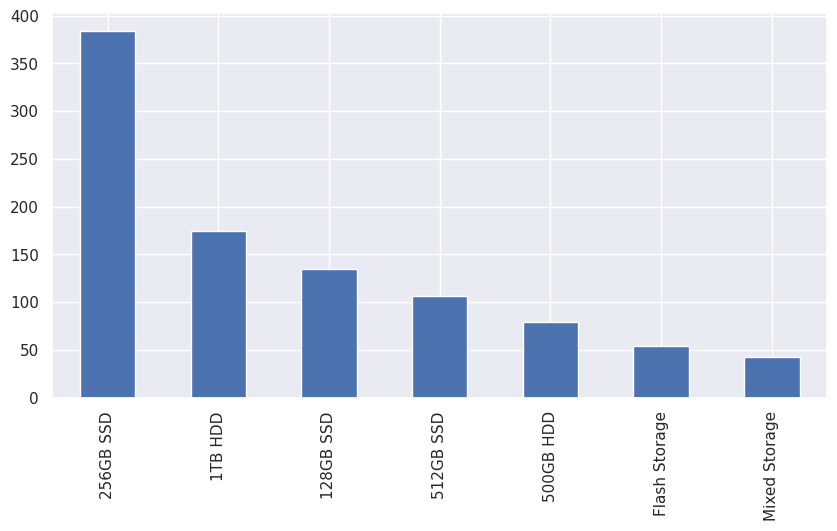

In [ ]:
plt.figure(figsize=(10,5))
data['Storage Type'].value_counts().plot(kind='bar')

# Exploratory Data Analysis

In [ ]:
data.select_dtypes(include='object').nunique()

Manufacturer                 19
Model Name                  488
Category                      6
Screen                       38
CPU                         106
RAM                           8
 Storage                     36
GPU                          98
Operating System              6
Operating System Version      4
CPU brand                     5
GPU brand                     3
Screen Quality               16
Storage Type                  7
dtype: int64

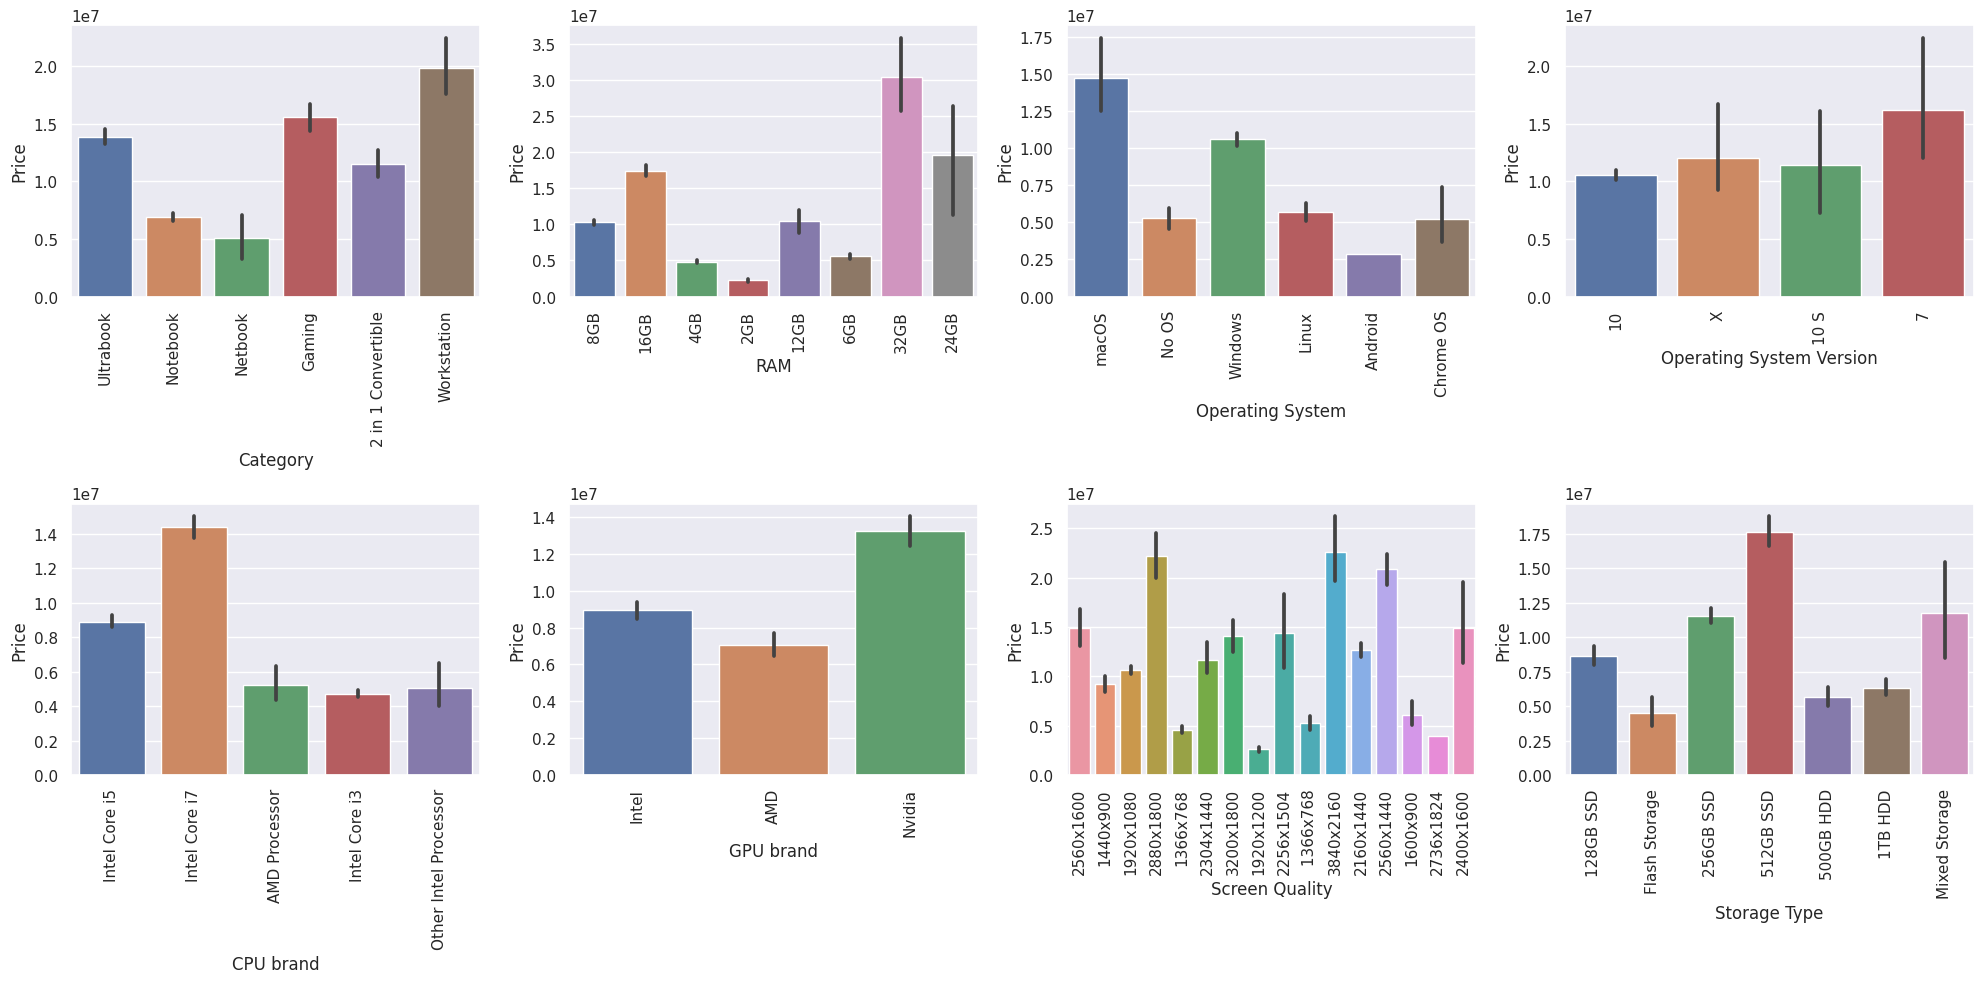

In [ ]:
# list of categorical variables to plot
cat_vars = ['Category', 'RAM', 'Operating System', 'Operating System Version', 'CPU brand', 'GPU brand', 'Screen Quality', 'Storage Type']

# create figure with subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axs = axs.flatten()

# create barplot for each categorical variable
for i, var in enumerate(cat_vars):
    sns.barplot(x=var, y='Price', data=data, ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)

# adjust spacing between subplots
fig.tight_layout()

# show plot
plt.show()

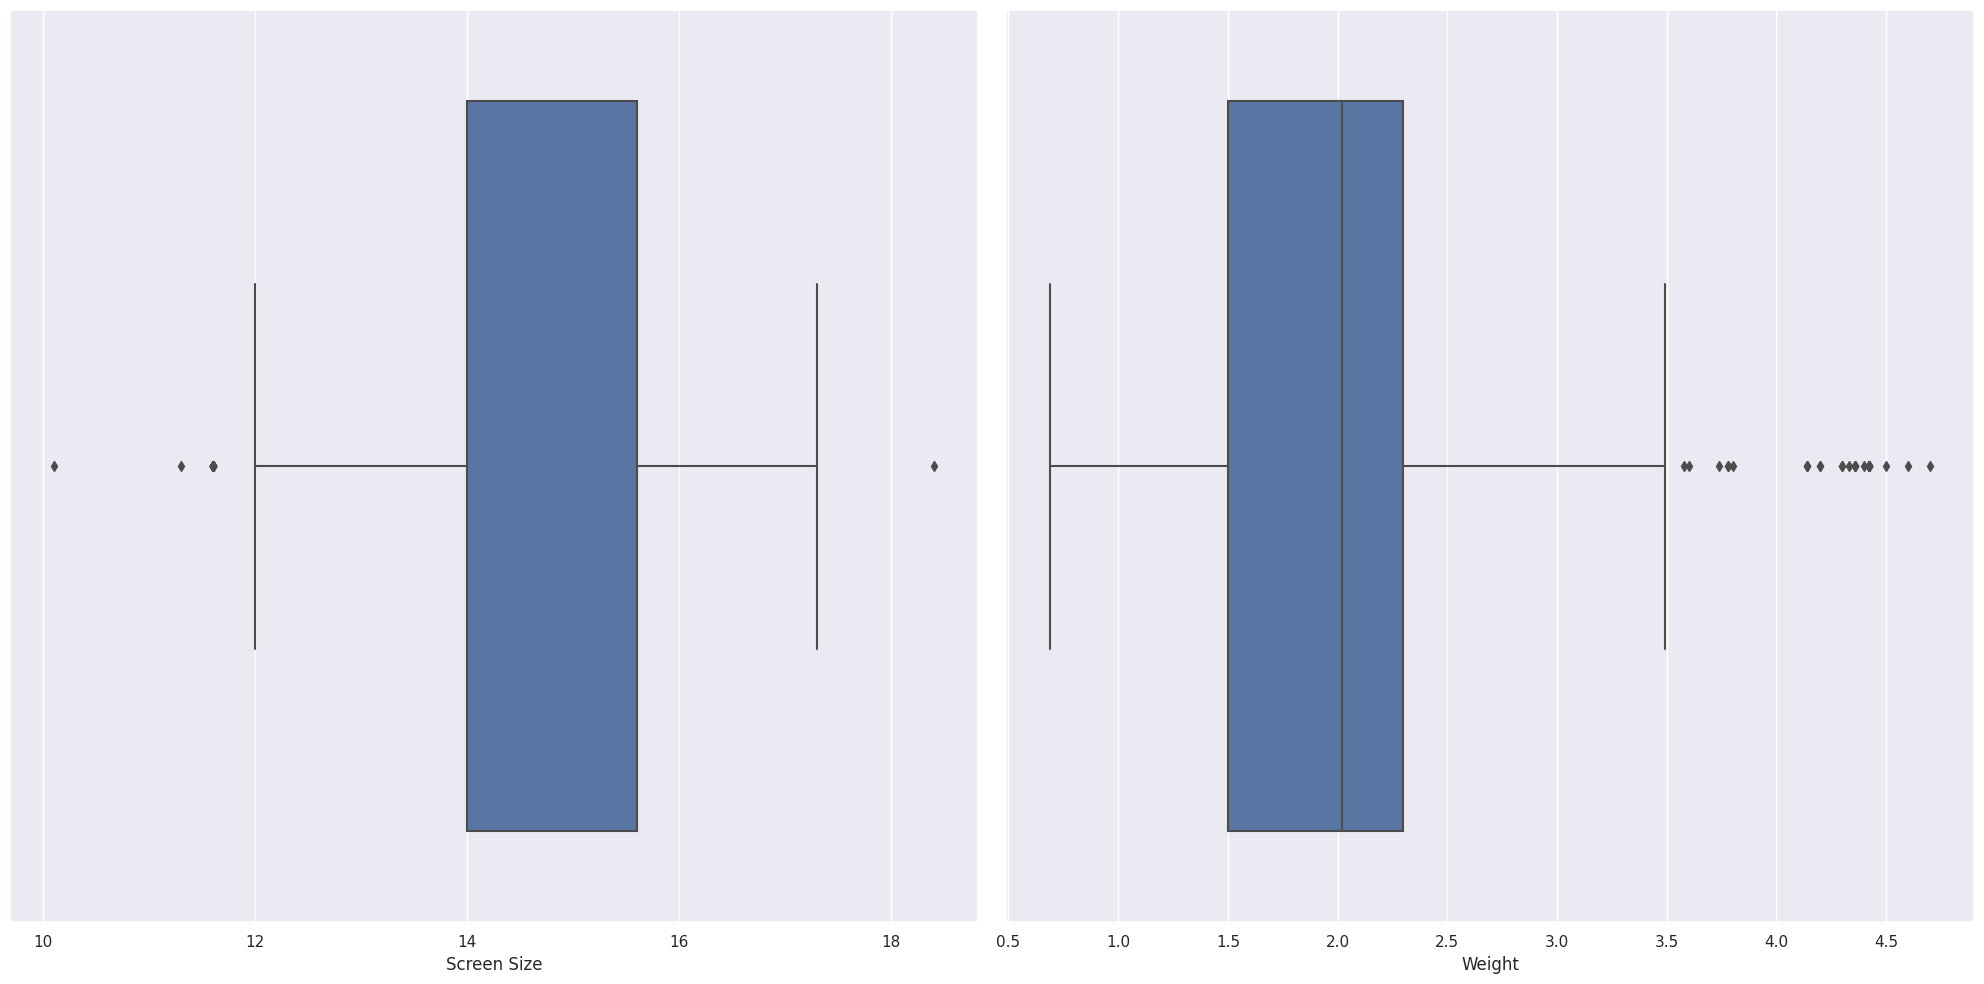

In [ ]:
num_vars = ['Screen Size', 'Weight']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axs = axs.flatten()

for i, var in enumerate(num_vars):
    sns.boxplot(x=var, data=data, ax=axs[i])

fig.tight_layout()

plt.show()

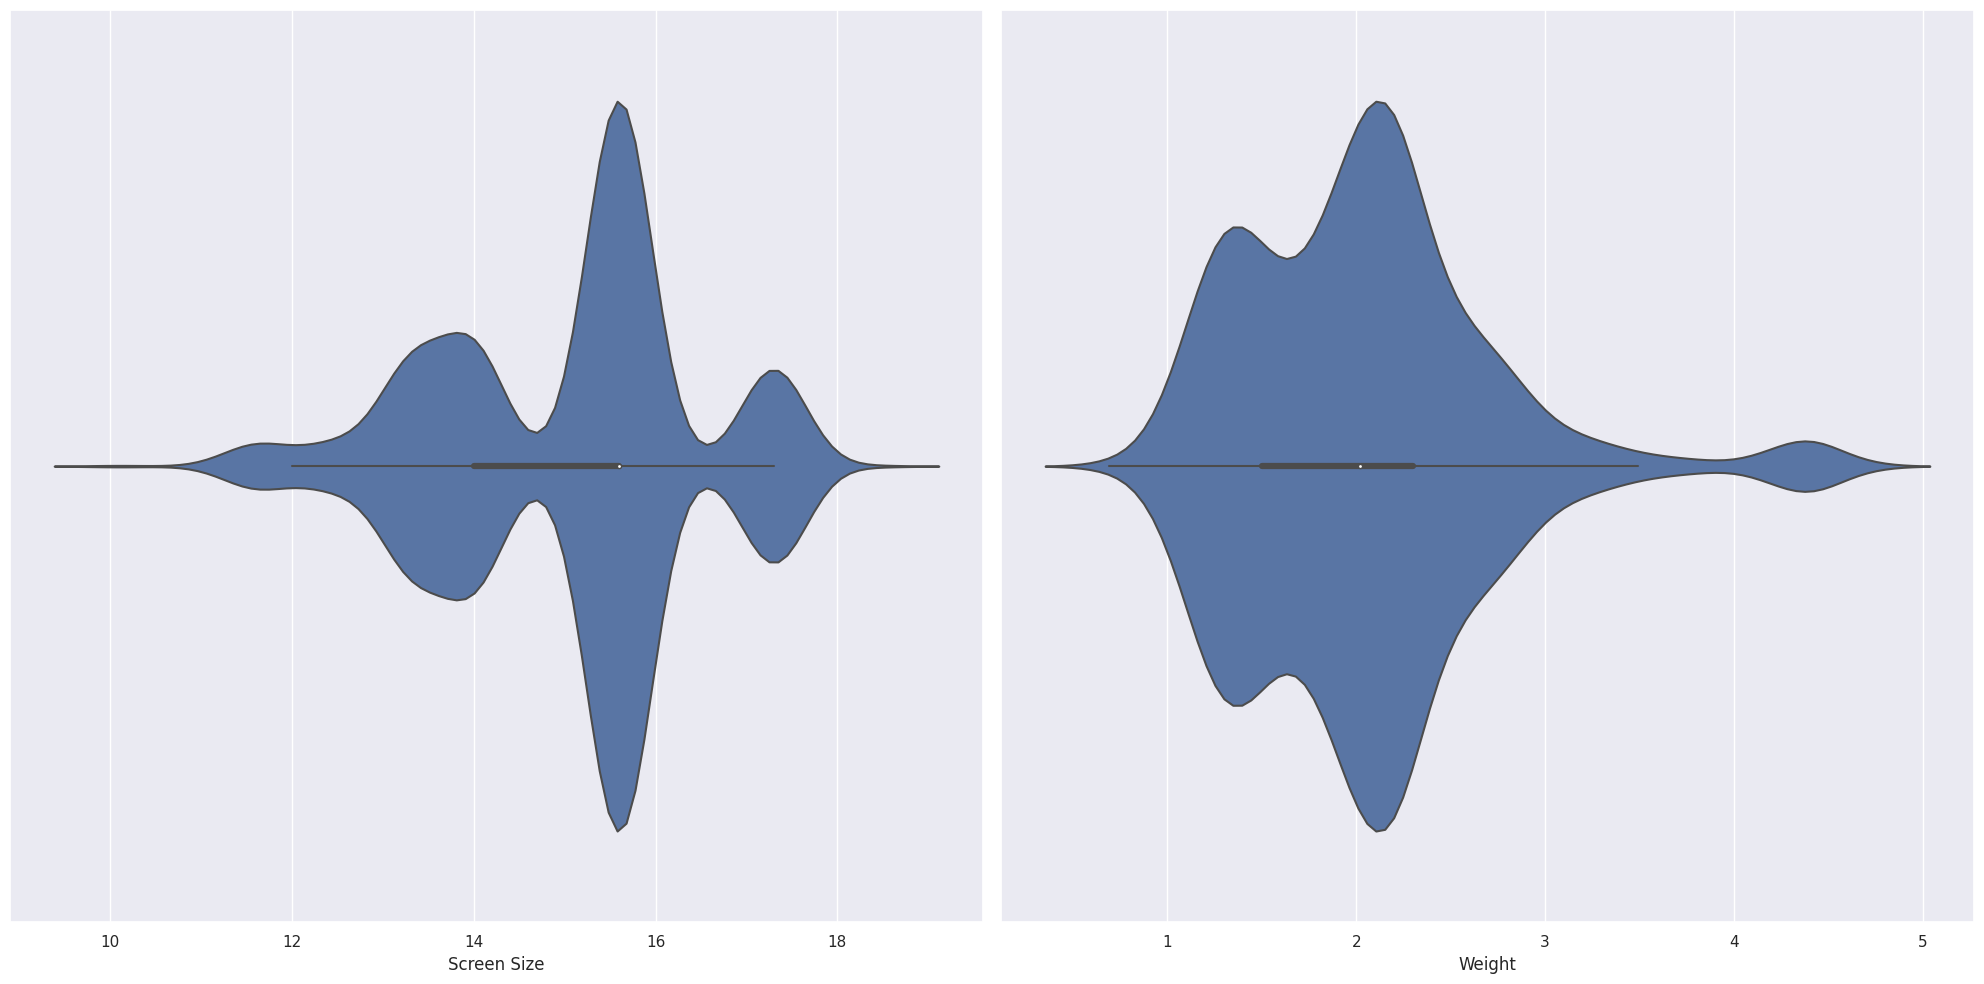

In [ ]:
num_vars = ['Screen Size', 'Weight']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axs = axs.flatten()

for i, var in enumerate(num_vars):
    sns.violinplot(x=var, data=data, ax=axs[i])

fig.tight_layout()

plt.show()

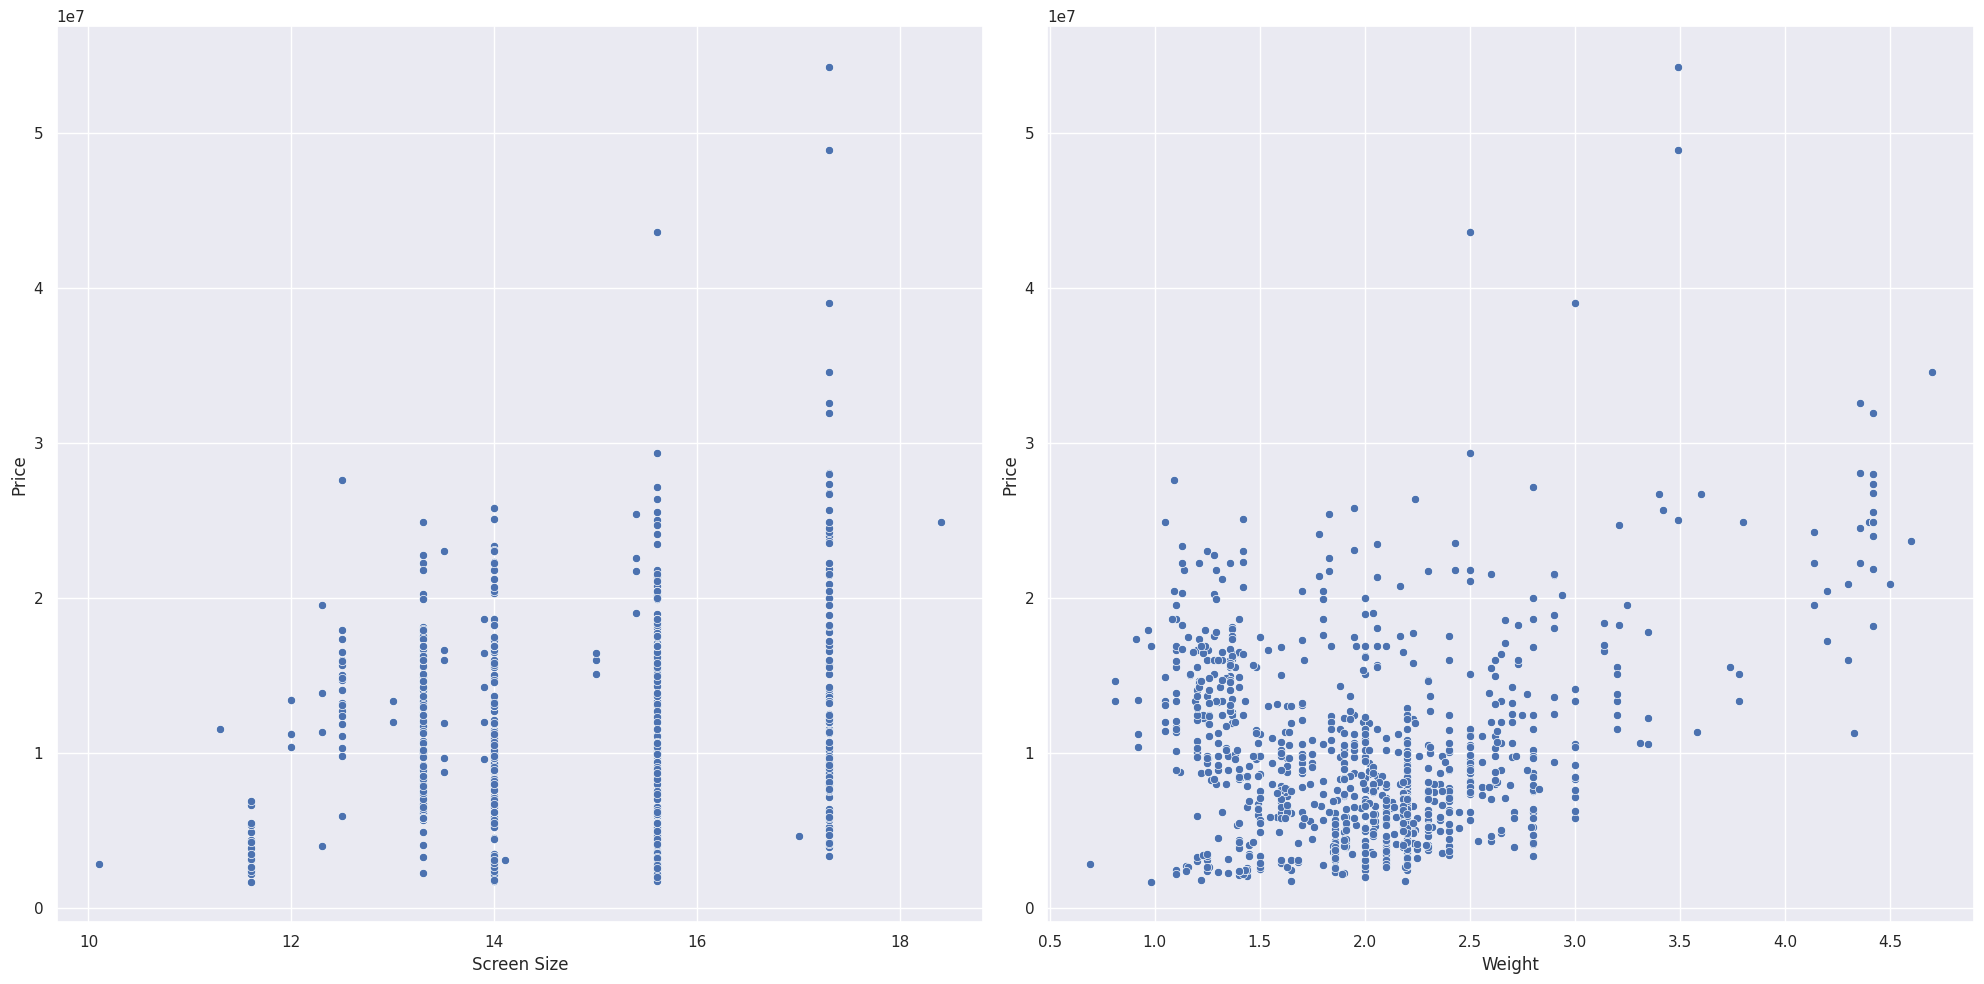

In [ ]:
num_vars = ['Screen Size', 'Weight']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axs = axs.flatten()

for i, var in enumerate(num_vars):
    sns.scatterplot(x=var, y='Price', data=data, ax=axs[i])

fig.tight_layout()

plt.show()

# Data Preprocessing Part 2

In [ ]:
data.drop(columns=['Model Name', 'Screen', 'CPU', ' Storage', 'GPU'], inplace=True)
data.shape

(977, 12)

In [ ]:
data.head()

,Manufacturer,Category,Screen Size,RAM,Operating System,Operating System Version,Weight,Price,CPU brand,GPU brand,Screen Quality,Storage Type
0,Apple,Ultrabook,13.3,8GB,macOS,NaN,1.37,11912523.48,Intel Core i5,Intel,2560x1600,128GB SSD
1,Apple,Ultrabook,13.3,8GB,macOS,NaN,1.34,7993374.48,Intel Core i5,Intel,1440x900,Flash Storage
2,HP,Notebook,15.6,8GB,No OS,NaN,1.86,5112900.00,Intel Core i5,Intel,1920x1080,256GB SSD
3,Apple,Ultrabook,15.4,16GB,macOS,NaN,1.83,22563005.40,Intel Core i7,AMD,2880x1800,512GB SSD
4,Apple,Ultrabook,13.3,8GB,macOS,NaN,1.37,16037611.20,Intel Core i5,Intel,2560x1600,256GB SSD


In [ ]:
check_missing = data.isnull().sum() * 100 / data.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

Operating System Version    13.920164
dtype: float64

In [ ]:
data.fillna('Unknown', inplace=True)
data.head()

,Manufacturer,Category,Screen Size,RAM,Operating System,Operating System Version,Weight,Price,CPU brand,GPU brand,Screen Quality,Storage Type
0,Apple,Ultrabook,13.3,8GB,macOS,Unknown,1.37,11912523.48,Intel Core i5,Intel,2560x1600,128GB SSD
1,Apple,Ultrabook,13.3,8GB,macOS,Unknown,1.34,7993374.48,Intel Core i5,Intel,1440x900,Flash Storage
2,HP,Notebook,15.6,8GB,No OS,Unknown,1.86,5112900.00,Intel Core i5,Intel,1920x1080,256GB SSD
3,Apple,Ultrabook,15.4,16GB,macOS,Unknown,1.83,22563005.40,Intel Core i7,AMD,2880x1800,512GB SSD
4,Apple,Ultrabook,13.3,8GB,macOS,Unknown,1.37,16037611.20,Intel Core i5,Intel,2560x1600,256GB SSD


In [ ]:
# Loop over each column in the DataFrame where dtype is 'object'
for col in data.select_dtypes(include=['object']).columns:
    
    # Print the column name and the unique values
    print(f"{col}: {data[col].unique()}")

Manufacturer: ['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Chuwi' 'MSI' 'Microsoft'
 'Toshiba' 'Huawei' 'Xiaomi' 'Vero' 'Razer' 'Mediacom' 'Samsung' 'Google'
 'Fujitsu' 'LG']
Category: ['Ultrabook' 'Notebook' 'Netbook' 'Gaming' '2 in 1 Convertible'
 'Workstation']
RAM: ['8GB' '16GB' '4GB' '2GB' '12GB' '6GB' '32GB' '24GB']
Operating System: ['macOS' 'No OS' 'Windows' 'Linux' 'Android' 'Chrome OS']
Operating System Version: ['Unknown' '10' 'X' '10 S' '7']
CPU brand: ['Intel Core i5' 'Intel Core i7' 'AMD Processor' 'Intel Core i3'
 'Other Intel Processor']
GPU brand: ['Intel' 'AMD' 'Nvidia']
Screen Quality: ['2560x1600' '1440x900' '1920x1080' '2880x1800' '1366x768' '2304x1440'
 '3200x1800' '1920x1200' '2256x1504' ' 1366x768' '3840x2160' '2160x1440'
 '2560x1440' '1600x900' '2736x1824' '2400x1600']
Storage Type: ['128GB SSD' 'Flash Storage' '256GB SSD' '512GB SSD' '500GB HDD' '1TB HDD'
 'Mixed Storage']


In [ ]:
from sklearn import preprocessing

# Loop over each column in the DataFrame where dtype is 'object'
for col in data.select_dtypes(include=['object']).columns:
    
    # Initialize a LabelEncoder object
    label_encoder = preprocessing.LabelEncoder()
    
    # Fit the encoder to the unique values in the column
    label_encoder.fit(data[col].unique())
    
    # Transform the column using the encoder
    data[col] = label_encoder.transform(data[col])
    
    # Print the column name and the unique encoded values
    print(f"{col}: {data[col].unique()}")

Manufacturer: [ 1  7  0  2  4 10  3 11 13 16  8 18 17 14 12 15  6  5  9]
Category: [4 3 2 1 0 5]
RAM: [7 1 5 3 0 6 4 2]
Operating System: [5 3 4 2 0 1]
Operating System Version: [3 0 4 1 2]
CPU brand: [2 3 0 1 4]
GPU brand: [1 0 2]
Screen Quality: [11  2  4 13  1  8 14  5  7  0 15  6 10  3 12  9]
Storage Type: [0 5 2 4 3 1 6]


In [ ]:
data.dtypes

Manufacturer                  int64
Category                      int64
Screen Size                 float64
RAM                           int64
Operating System              int64
Operating System Version      int64
Weight                      float64
Price                       float64
CPU brand                     int64
GPU brand                     int64
Screen Quality                int64
Storage Type                  int64
dtype: object

# Remove Outlier Using Z-Score

In [ ]:
from scipy import stats

# define a function to remove outliers using z-score for only selected numerical columns
def remove_outliers(data, cols, threshold=3):
    # loop over each selected column
    for col in cols:
        # calculate z-score for each data point in selected column
        z = np.abs(stats.zscore(data[col]))
        # remove rows with z-score greater than threshold in selected column
        data = data[(z < threshold) | (data[col].isnull())]
    return data

In [ ]:
selected_cols = ['Screen Size', 'Weight']
df_clean = remove_outliers(data, selected_cols)
df_clean.shape

(949, 12)

<Axes: >

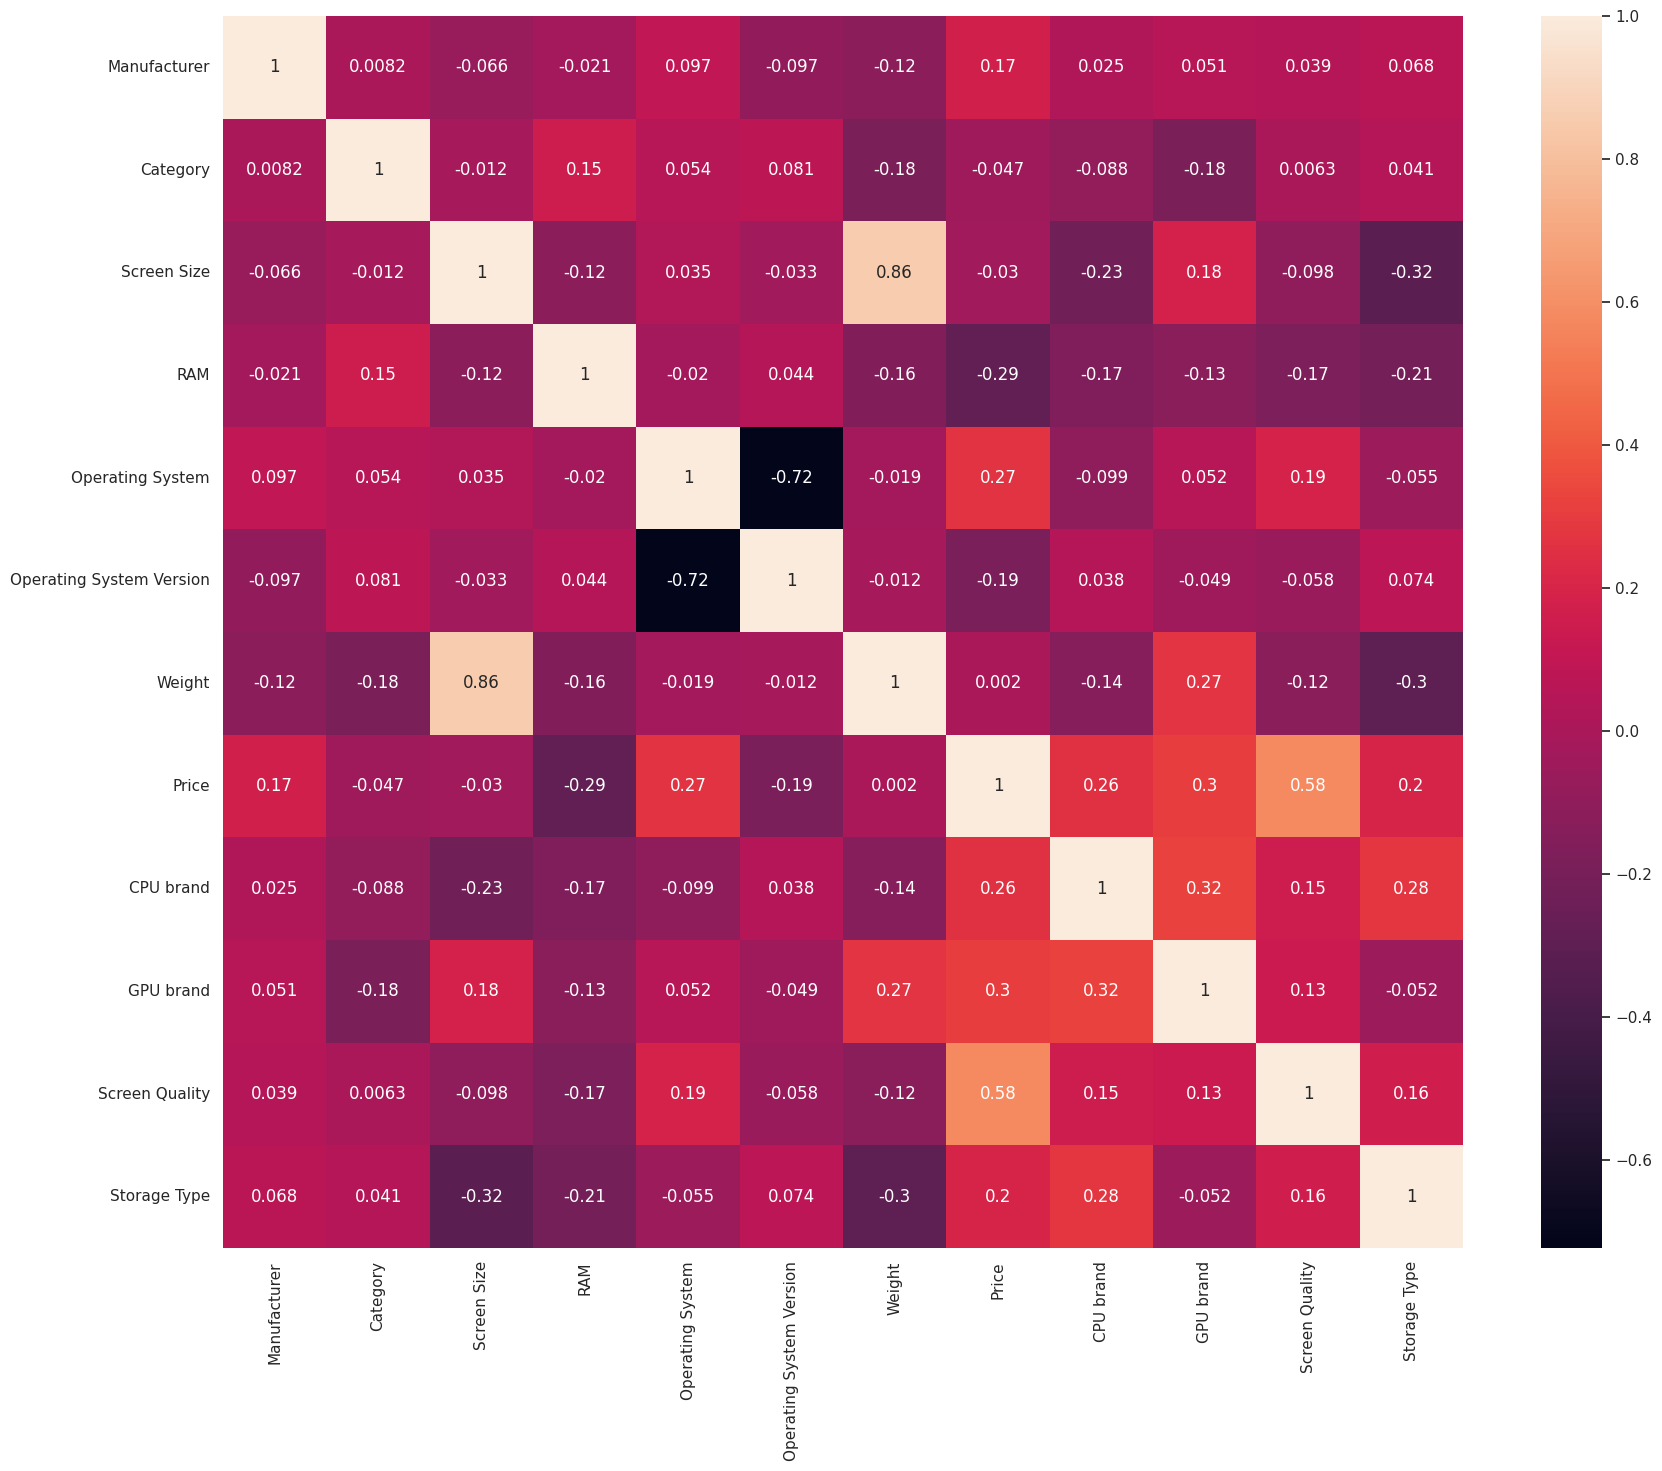

In [ ]:
#Correlation Heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(df_clean.corr(), fmt='.2g', annot=True)

# Machine Learning Model Building

In [ ]:
X = df_clean.drop('Price', axis=1)
y = df_clean['Price']

In [ ]:
#test size 20% and train size 80%
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

# Model Comparison

In [ ]:
# Create a list of regression models
models = [("Linear Regression", LinearRegression()),
          ("SVM", SVR()),
          ("Decision Tree", DecisionTreeRegressor()),
          ("Random Forest", RandomForestRegressor(n_estimators=100)),
          ("XGBoost", XGBRegressor())]

# Create a dataframe to store the evaluation metrics
results = pd.DataFrame(columns=["Model", "RMSE", "MAE", "R2"])

In [ ]:
# Evaluate each model and store the results in the dataframe
for name, model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Calculate the evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Add the results to the dataframe
    results = results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}, ignore_index=True)

# Sort the dataframe by the weighted score
results["Score"] = 0.5 * results["RMSE"] + 0.25 * results["MAE"] + 0.25 * results["R2"]
results = results.sort_values("Score")

# Print the results
print(results)

<ipython-input-42-84950be424f6>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}, ignore_index=True)
<ipython-input-42-84950be424f6>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}, ignore_index=True)
<ipython-input-42-84950be424f6>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}, ignore_index=True)
<ipython-input-42-84950be424f6>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(

               Model          RMSE           MAE        R2         Score
3      Random Forest  2.831036e+06  1.699312e+06  0.761804  1.840346e+06
4            XGBoost  3.017001e+06  1.687182e+06  0.729483  1.930296e+06
2      Decision Tree  3.449197e+06  2.138043e+06  0.646427  2.259109e+06
0  Linear Regression  4.630268e+06  3.320150e+06  0.362830  3.145171e+06
1                SVM  5.977141e+06  4.414994e+06 -0.061769  4.092319e+06


<ipython-input-42-84950be424f6>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}, ignore_index=True)


# Random Forest Regressor

In [ ]:
# Define objective function to be minimized by Optuna
def objective(trial):
    # Define range of hyperparameters to be tuned
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, 100)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # Create random forest regressor model with given hyperparameters
    model = RandomForestRegressor(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   max_features=max_features,
                                   bootstrap=bootstrap,
                                   random_state=42)

    # Train model and make predictions on validation set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate mean squared error and return as objective value
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Create Optuna study and optimize objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print best hyperparameters and objective value
print(f'Best parameters: {study.best_params}')
print(f'Best MSE: {study.best_value}')

[I 2023-04-22 10:26:14,463] A new study created in memory with name: no-name-51f91d74-1eb7-45c8-8421-3dbb6be391ba
[I 2023-04-22 10:26:19,212] Trial 0 finished with value: 8960535317994.34 and parameters: {'n_estimators': 900, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 8960535317994.34.
[I 2023-04-22 10:26:21,054] Trial 1 finished with value: 9939892395655.318 and parameters: {'n_estimators': 700, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 8960535317994.34.
[I 2023-04-22 10:26:21,885] Trial 2 finished with value: 10030687979500.91 and parameters: {'n_estimators': 300, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 8960535317994.34.
[I 2023-04-22 10:26:23,151] Trial 3 finished with value: 9144674758987.14 and parameters: 

Best parameters: {'n_estimators': 900, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
Best MSE: 7306821331291.864


In [ ]:
# Define the model
model = RandomForestRegressor(**study.best_params)

# Fit the model on training data
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('R2 score: {:.2f}'.format(r2))

RMSE: 2759925.03
MAE: 1709016.30
R2 score: 0.77


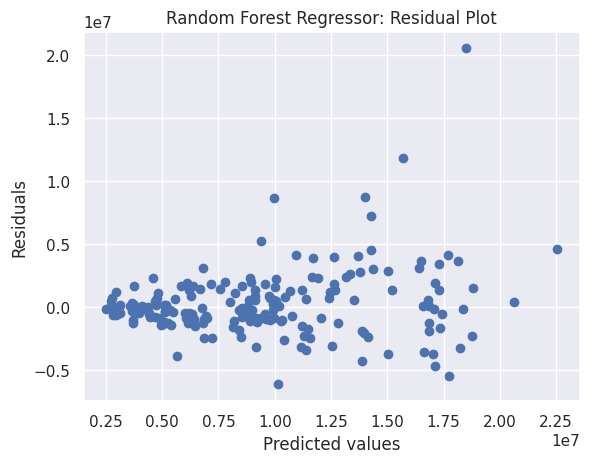

In [ ]:
residuals = y_test - y_pred

# Create a scatter plot of predicted values vs residuals
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Random Forest Regressor: Residual Plot")
plt.show()

# Feature Importances

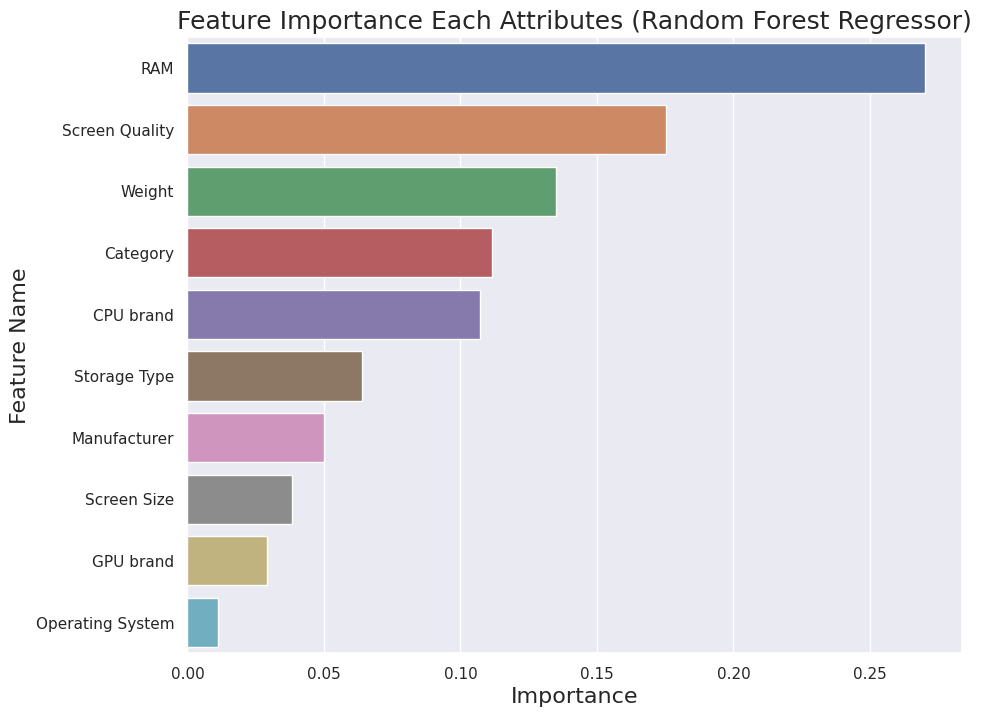

In [ ]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": model.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Feature Importance Each Attributes (Random Forest Regressor)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()